# Hanna evaluation notebook

## 1 - Installation and dependencies

In [ ]:
!pip install -r ../requirements.txt

In [1]:
import pandas as pd
import numpy as np 
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torch 
import transformers
from nlg_eval_via_simi_measures.bary_score import BaryScoreMetric
from nlg_eval_via_simi_measures.depth_score import DepthScoreMetric
from nlg_eval_via_simi_measures.infolm import InfoLM
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate import meteor
from nltk import word_tokenize
from nltk import download
from bert_score import score
from rouge import Rouge 

In [ ]:
download('punkt')
download('wordnet')

## 2 - Scores and correlations functions

Where we define the function that we later be used to compute the scores and correlations.

In [ ]:
# BaryScore

def compute_bary(ref:str,hypothesis:str):
    ref,hypothesis=[ref],[hypothesis]
    metric_call = BaryScoreMetric()
    metric_call.prepare_idfs(ref, hypothesis)
    return metric_call.evaluate_batch(ref, hypothesis)["baryscore_W"][0]

In [ ]:
# DepthScore

def compute_depthscore(ref:str,hypothesis:str):
    metric_call = DepthScoreMetric()
    metric_call.prepare_idfs(ref, hypothesis)
    return metric_call.evaluate_batch(hypothesis,ref)["depth_score"][0]

In [ ]:
# InfoLM

def compute_infolmscore(ref:str,hypothesis:str):
    ref,hypothesis=[ref],[hypothesis]
    metric = InfoLM()
    #metric.device="cpu"
    #metric.model.to("cpu")
    metric.prepare_idfs(ref, hypothesis)
    return metric.evaluate_batch(hypothesis, ref)["fisher_rao"][0]

In [ ]:
# BLEU

def compute_bleuscore(ref:str,hypothesis:str):
    ref,hypothesis=[word_tokenize(ref)],word_tokenize(hypothesis)
    return sentence_bleu(ref,hypothesis)

In [ ]:
# BERTScore

def compute_bertscore(ref:str,hypothesis:str):
    ref,hypothesis=[ref],[hypothesis]
    P, R, F1=score(hypothesis, ref, lang="en", verbose=True)
    return P.item(),R.item(),F1.item()

In [ ]:
# BARTSCore function

import torch
import torch.nn as nn
import traceback
from transformers import BartTokenizer, BartForConditionalGeneration
from typing import List
import numpy as np


class BARTScorer:
    def __init__(self, device='cuda:0', max_length=1024, checkpoint='facebook/bart-large-cnn'):
        # Set up model
        self.device = device
        self.max_length = max_length
        self.tokenizer = BartTokenizer.from_pretrained(checkpoint)
        self.model = BartForConditionalGeneration.from_pretrained(checkpoint)
        self.model.eval()
        self.model.to(device)

        # Set up loss
        self.loss_fct = nn.NLLLoss(reduction='none', ignore_index=self.model.config.pad_token_id)
        self.lsm = nn.LogSoftmax(dim=1)

    def load(self, path=None):
        """ Load model from paraphrase finetuning """
        if path is None:
            path = 'models/bart.pth'
        self.model.load_state_dict(torch.load(path, map_location=self.device))

    def score(self, srcs, tgts, batch_size=4):
        """ Score a batch of examples """
        score_list = []
        for i in range(0, len(srcs), batch_size):
            src_list = srcs[i: i + batch_size]
            tgt_list = tgts[i: i + batch_size]
            try:
                with torch.no_grad():
                    encoded_src = self.tokenizer(
                        src_list,
                        max_length=self.max_length,
                        truncation=True,
                        padding=True,
                        return_tensors='pt'
                    )
                    encoded_tgt = self.tokenizer(
                        tgt_list,
                        max_length=self.max_length,
                        truncation=True,
                        padding=True,
                        return_tensors='pt'
                    )
                    src_tokens = encoded_src['input_ids'].to(self.device)
                    src_mask = encoded_src['attention_mask'].to(self.device)

                    tgt_tokens = encoded_tgt['input_ids'].to(self.device)
                    tgt_mask = encoded_tgt['attention_mask']
                    tgt_len = tgt_mask.sum(dim=1).to(self.device)

                    output = self.model(
                        input_ids=src_tokens,
                        attention_mask=src_mask,
                        labels=tgt_tokens
                    )
                    logits = output.logits.view(-1, self.model.config.vocab_size)
                    loss = self.loss_fct(self.lsm(logits), tgt_tokens.view(-1))
                    loss = loss.view(tgt_tokens.shape[0], -1)
                    loss = loss.sum(dim=1) / tgt_len
                    curr_score_list = [-x.item() for x in loss]
                    score_list += curr_score_list

            except RuntimeError:
                traceback.print_exc()
                print(f'source: {src_list}')
                print(f'target: {tgt_list}')
                exit(0)
        return score_list

    def multi_ref_score(self, srcs, tgts: List[List[str]], agg="mean", batch_size=4):
        # Assert we have the same number of references
        ref_nums = [len(x) for x in tgts]
        if len(set(ref_nums)) > 1:
            raise Exception("You have different number of references per test sample.")

        ref_num = len(tgts[0])
        score_matrix = []
        for i in range(ref_num):
            curr_tgts = [x[i] for x in tgts]
            scores = self.score(srcs, curr_tgts, batch_size)
            score_matrix.append(scores)
        if agg == "mean":
            score_list = np.mean(score_matrix, axis=0)
        elif agg == "max":
            score_list = np.max(score_matrix, axis=0)
        else:
            raise NotImplementedError
        return list(score_list)

In [ ]:
# BARTSCore

def compute_bartscore(ref:str,hypothesis:str):
    ref,hypothesis=[ref],[hypothesis]
    bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')
    return bart_scorer.multi_ref_score(hypothesis, ref, agg="max", batch_size=4)[0] # agg means aggregation, can be mean or max

In [ ]:
# METEOR

def compute_meteorscore(ref:str,hypothesis:str):
    return round(meteor([word_tokenize(ref)],word_tokenize(hypothesis)),4)

In [ ]:
# ROUGE

def id(r,p,f):
    return r,p,f

def compute_rougescore(ref:str,hypothesis:str):
    rouge = Rouge() 
    return id(**rouge.get_scores([hypothesis], [ref])[0]['rouge-1'])


In [27]:
# Functions regarding the computation of correlations

def compute_two_corr(dataframe:pd.DataFrame, column_name_1:str, column_name_2:str,correlation_type:str, system:str):
    return dataframe[dataframe.Model==system][[column_name_1,column_name_2]].corr(method=correlation_type,numeric_only=True)

def compute_list_corr(dataframe:pd.DataFrame, list_column_name:str, correlation_type:str, system:str=None): #list_column_name:list[str]
    if system:
        return dataframe[dataframe.Model==system][list_column_name].corr(method=correlation_type)
    else:
        return dataframe[list_column_name].corr(method=correlation_type)

# Transforms a correlation matrix: absolute value (since we are only interested in the strengh of the association), percentage

def format_corr(corr):
    return 100*np.abs(corr)

## 3 - DL and datawrangling of Hanna dataset

In [ ]:
# Importation of the dataset
df = pd.read_csv("https://github.com/dig-team/hanna-benchmark-asg/raw/main/hanna_stories_annotations.csv")

# Selecting columns, dropping multiple lines corresponding to the human annotators
df_unique_human_story=df[df.Model!="Human"][["Story ID","Human","Story","Model"]].drop_duplicates(keep="first")

# Creation of an index
df_human_index=df.Human.drop_duplicates(keep="first").reset_index(drop=True).reset_index().rename(columns={"index":"human_story_index"})

# Mean of the scores given by the human annotators
df_mean_human_metrics=df.groupby("Story ID").mean()

## 4 - Compute scores

In [ ]:
# Heavy computation
df_unique_human_story['baryscore']= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_bary(*x), axis =1)
df_unique_human_story['depthscore']= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_depthscore(*x), axis =1)
df_unique_human_story['infolmscore']= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_infolmscore(*x), axis =1)
df_unique_human_story['BLEU']= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_bleuscore(*x), axis =1)
df_unique_human_story[['ROUGE_r','ROUGE_p','ROUGE_f']]= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_rougescore(*x), axis =1, result_type="expand")
df_unique_human_story['meteorscore']= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_meteorscore(*x), axis =1)
df_unique_human_story['bartscore']= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_bartscore(*x), axis =1)
df_unique_human_story[['bertscore_p','bertscore_r','bertscore_f1']]= df_unique_human_story[["Human", "Story"]].apply(lambda x : compute_bertscore(*x), axis =1, result_type="expand")

In [ ]:
# Random numbers (for checking the rest of the code without doing the heavy computation)
# df_unique_human_story['baryscore']= np.random.rand(960)
# df_unique_human_story['depthscore']= np.random.rand(960)
# df_unique_human_story['infolmscore']= np.random.rand(960)
# df_unique_human_story['BLEU']= np.random.rand(960)
# df_unique_human_story[['ROUGE_r','ROUGE_p','ROUGE_f']]= np.random.rand(960,3)
# df_unique_human_story['meteorscore']= np.random.rand(960)
# df_unique_human_story['bartscore']= np.random.rand(960)
# df_unique_human_story[['bertscore_p','bertscore_r','bertscore_f1']]= np.random.rand(960,3)

In [ ]:
# Merging the computed metrix with the human scores
df_unique_human_story_all=df_mean_human_metrics.merge(df_unique_human_story, how="left", on="Story ID")

# Adding an index for the story (one per prompt)
df_unique_human_story_all=df_unique_human_story_all.merge(df_human_index,on="Human")

In [ ]:
df_unique_human_story_all.to_parquet("hanna_scores_computed.parquet")

In [ ]:
# Checking the dataframe
df_unique_human_story_all.head(3)

## 5 - Compute correlations

In [3]:
LIST_HUMAN_METRICS=['Relevance', 'Coherence', 'Empathy', 'Surprise', 'Engagement', 'Complexity']
LIST_AEM=['baryscore', 'depthscore', 'infolmscore', 'BLEU', 'ROUGE_r', 'ROUGE_p', 'ROUGE_f', 
          'meteorscore', 'bartscore', 'bertscore_p', 'bertscore_r', 'bertscore_f1']
LIST_ALL_METRICS=LIST_HUMAN_METRICS+LIST_AEM
CORR_METHODS=["pearson", "kendall", "spearman"]

In [4]:
# Import the file containing the result of the heavy coputations
df_unique_human_story_all=pd.read_parquet("hanna_scores_computed.parquet")

### Text-level correlation
The text-level correlation $C_{t,f}$ writes:
$$C_{t,f} \triangleq \frac{1}{N}\sum_{i=1}^N K(\pmb{F}_i^t, \pmb{H}_i^t)$$
where $\pmb{F}_i = [f(\pmb{x_i},\pmb{y_i^1}), ..., f(\pmb{x_i},\pmb{y_i^S})]$ and $\pmb{H}_i = [h(\pmb{x_i},\pmb{y_i^1}), ..., h(\pmb{x_i},\pmb{y_i^S})]$ are the vectors composed of scores assigned by the automatic metric f and the human metric (h) respectively and $K: \mathbb{R}^N \times \mathbb{R}^N \rightarrow [-1,1]$ is the chosen correlation measure. [1, 2]

pearson


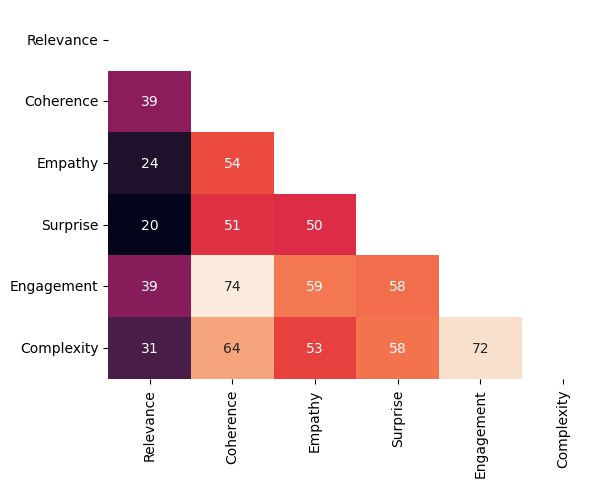

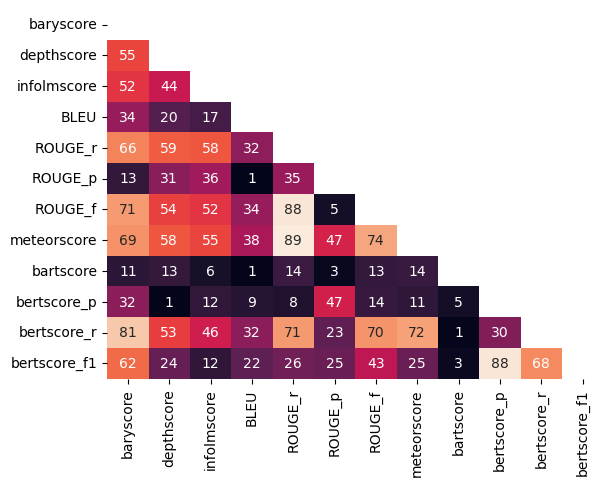

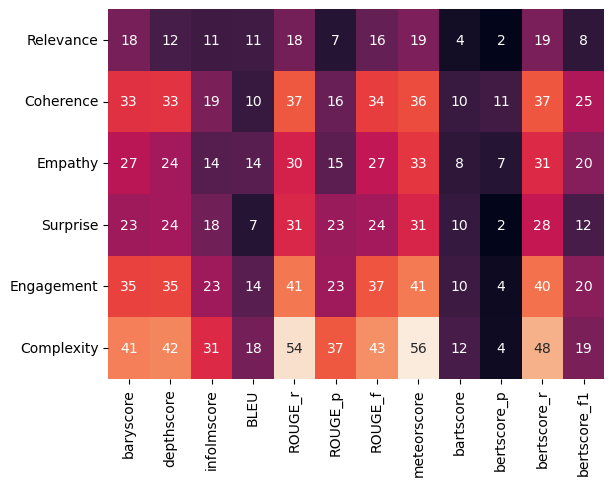

kendall


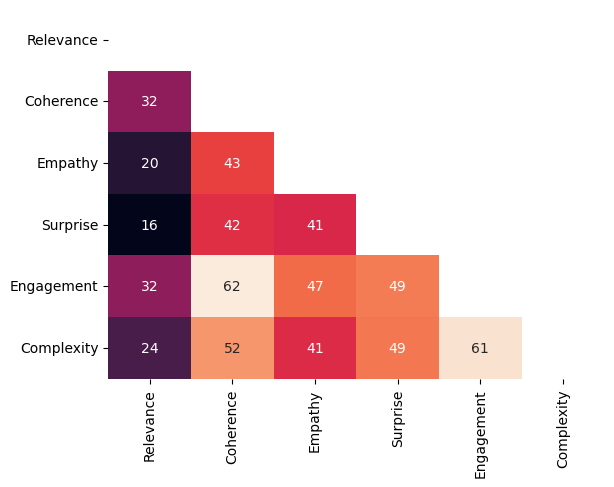

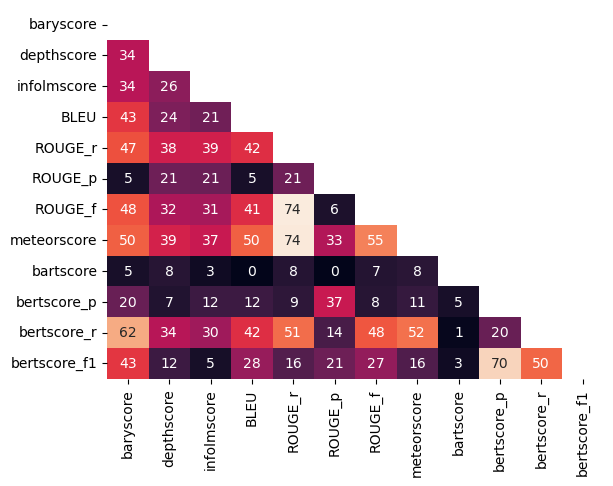

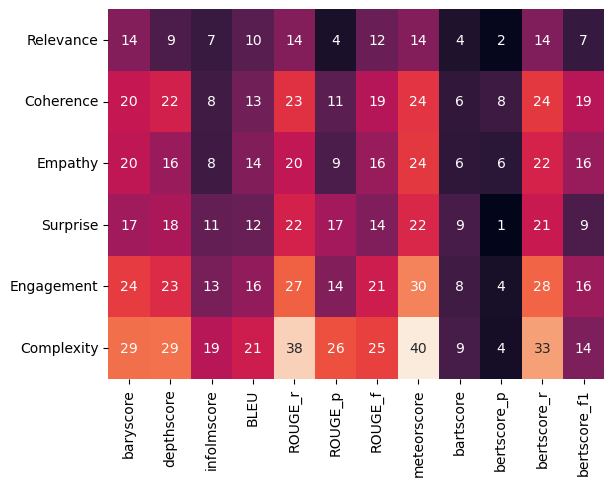

spearman


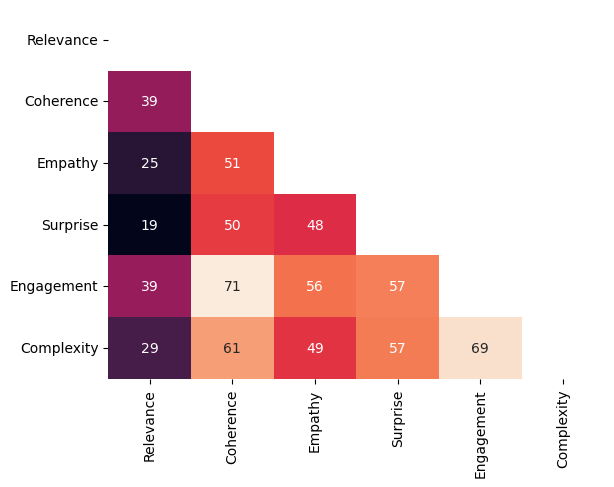

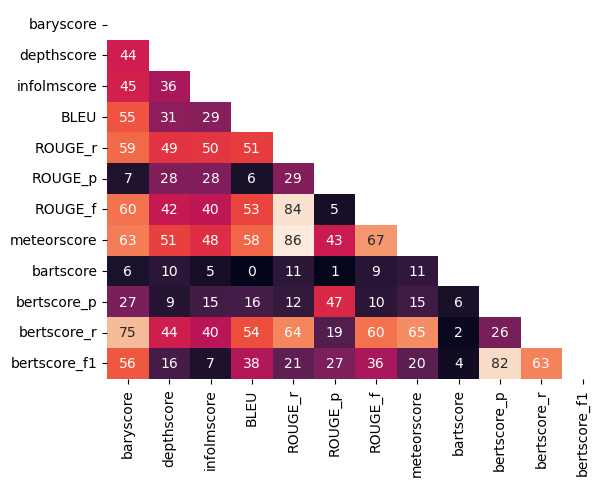

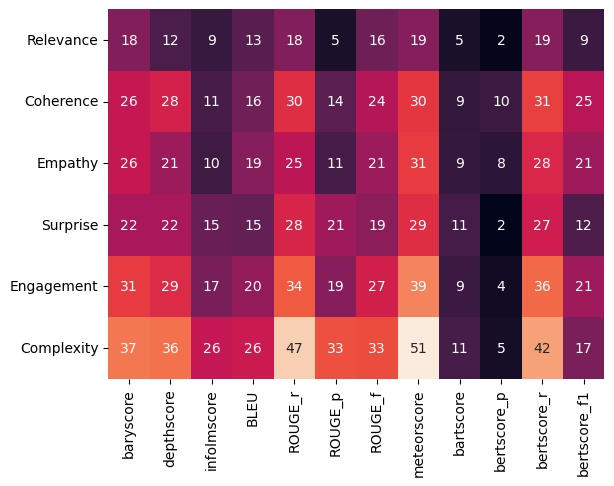

In [31]:
for corr_method in CORR_METHODS:
    print(corr_method)
    # For each gold, compute AEM + HM (provided)

    # >>> Done in  df_unique_human_story_all
    df_work=df_unique_human_story_all.copy()
    df_work=df_work.drop(columns=["Human","Story","Work time in seconds","Story ID"])
    # For each gold (96), compute correlation 960 => 96 
    list_of_dataframe=[]
    for index in iter(df_work.human_story_index.unique()): # For each prompt ...
        # ... compute the correlation between each pairs of columns
        result=compute_list_corr(df_work[df_work["human_story_index"]==index], LIST_ALL_METRICS, corr_method)
        list_of_dataframe.append(result)

    # For each pair of metrics, we then compute the average other the 96 prompts
    # Take the mean sample
    #sns.heatmap(pd.DataFrame(np.mean(list(map(lambda x : x.to_numpy(),list_of_dataframe)),axis=0),columns=LIST_ALL_METRICS))
    all_corr=pd.concat(list_of_dataframe).groupby(level=0).mean().reindex(LIST_ALL_METRICS)
    corr=all_corr.loc[LIST_HUMAN_METRICS,LIST_HUMAN_METRICS]
    
    matrix = np.triu(corr)
    sns.heatmap(format_corr(corr),mask=matrix, annot=True, fmt=".0f", cbar = False)
    plt.savefig("figures/text-"+corr_method+"-human", bbox_inches='tight', dpi =300)
    plt.show()
    
    
    corr=all_corr.loc[LIST_AEM,LIST_AEM]
    matrix = np.triu(corr)
    sns.heatmap(format_corr(corr), mask=matrix,annot=True, fmt=".0f", cbar = False)
    plt.savefig("figures/text-"+corr_method+"-auto", bbox_inches='tight', dpi =300)
    plt.show()
    
    corr=all_corr.loc[LIST_HUMAN_METRICS,LIST_AEM]
    sns.heatmap(format_corr(corr),annot=True, fmt=".0f", cbar = False)
    plt.savefig("figures/text-"+corr_method+"-autohuman", bbox_inches='tight', dpi =300)
    plt.show()

### System level correlation

Similarly, the system level correlation $C_{sy,f}$ writes: 
$$C_{sy,f} \triangleq K(\pmb{F}^{sy}, \pmb{H}^{sy})$$
$$\pmb{F}^{sy} = \left[\frac{1}{N}\sum_{i=1}^Nf(\pmb{x_i, y_i^1}), ...,  \frac{1}{N}\sum_{i=1}^Nf(\pmb{x_i, y_i^S})\right]$$
$$\pmb{H}^{sy} = \left[\frac{1}{N}\sum_{i=1}^Nh(\pmb{x_i, y_i^1}), ...,  \frac{1}{N}\sum_{i=1}^Nh(\pmb{x_i, y_i^S})\right]$$
Where the latter are the vectors composed of the averaged scores assigned by the automatic metric f and the human annotation h. [1,2] 

pearson


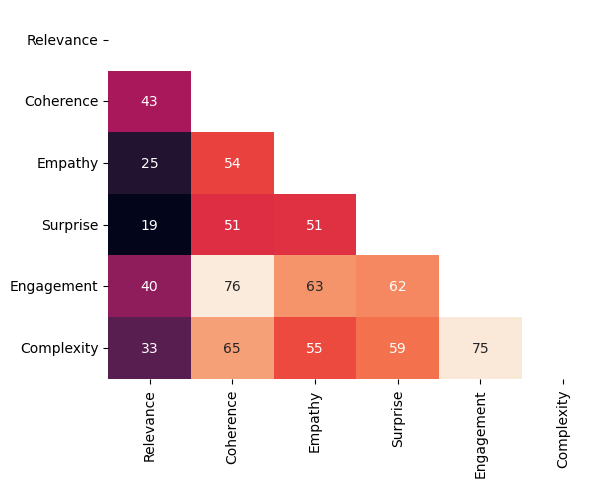

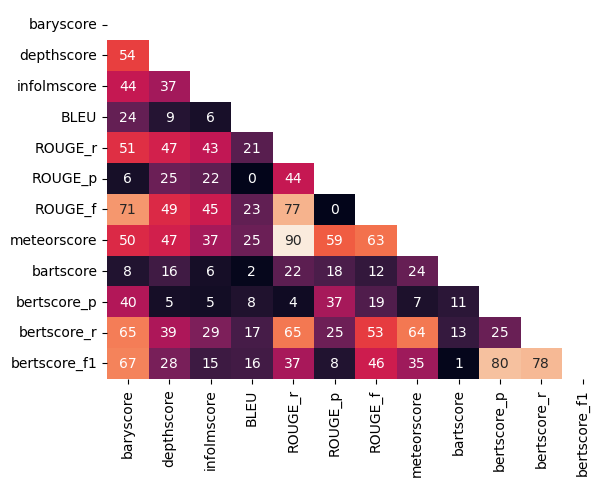

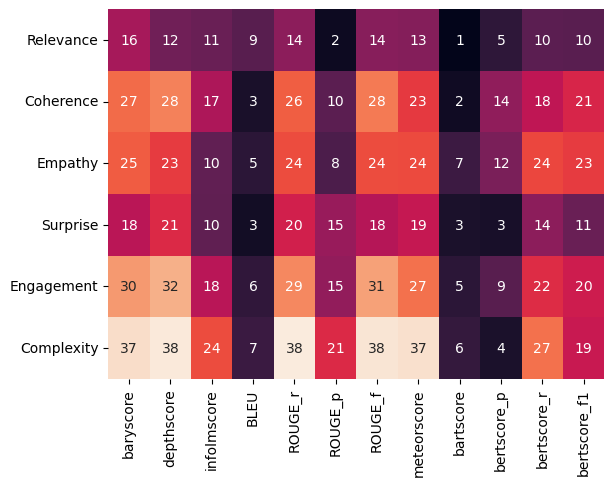

kendall


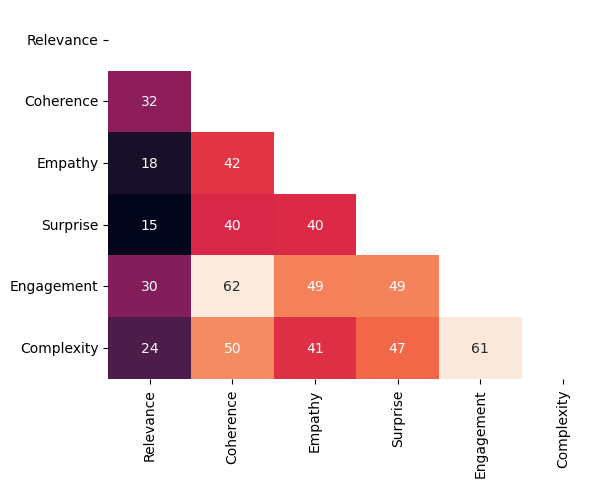

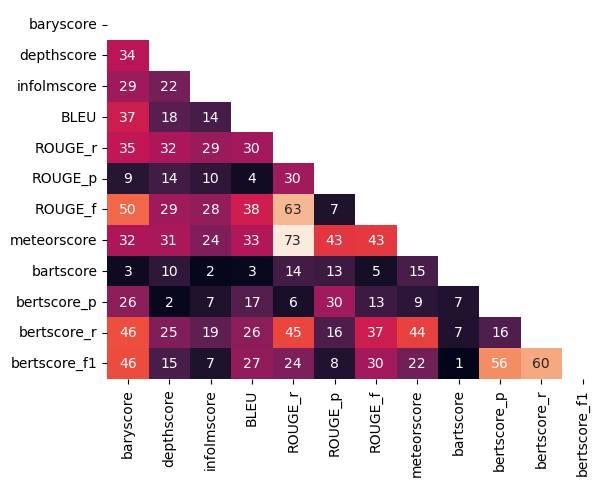

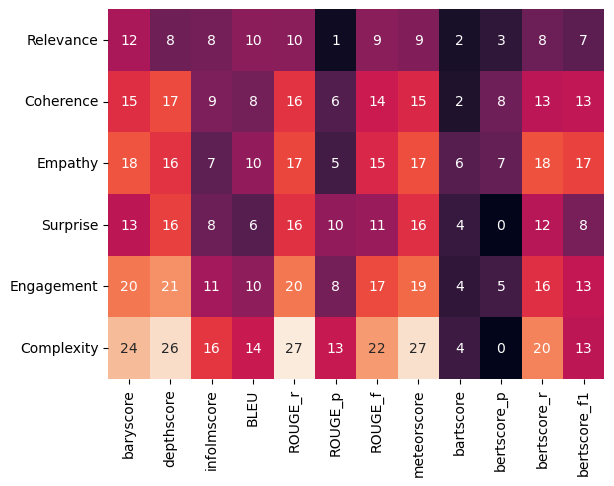

spearman


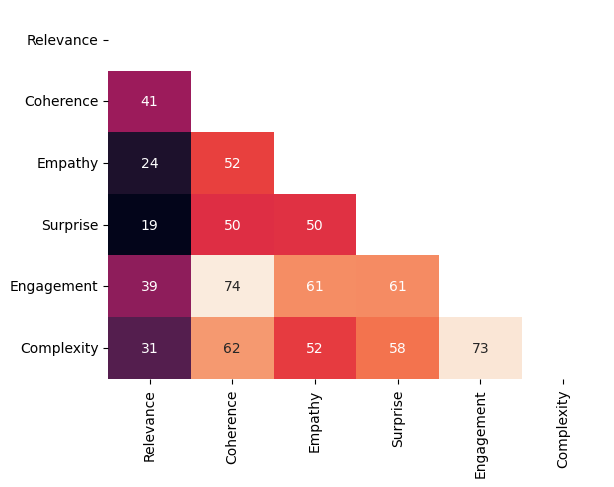

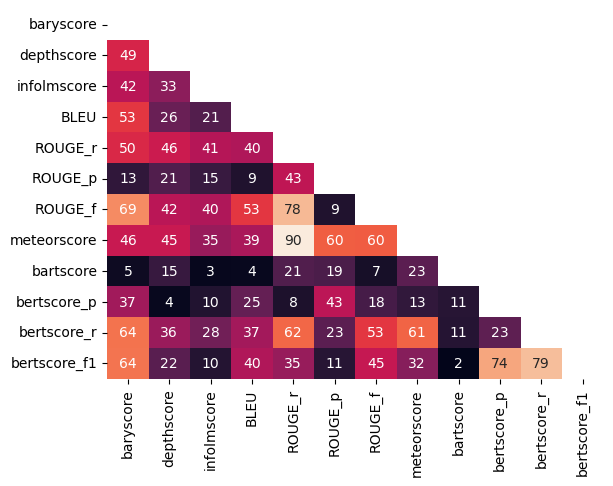

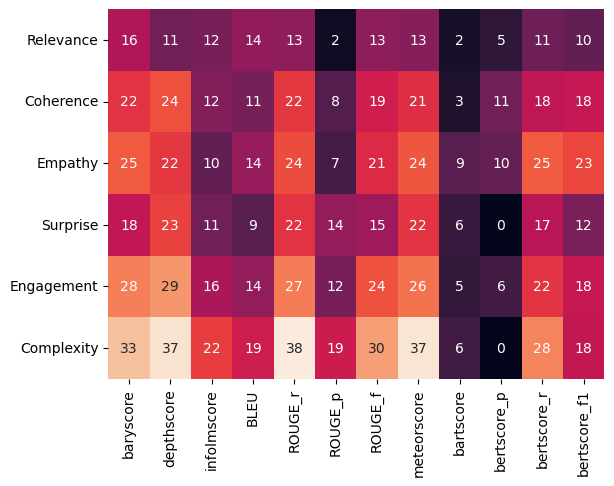

In [32]:
for corr_method in CORR_METHODS:
    print(corr_method)
    # For each gold, compute AEM + HM (provided)

    # >>> Done in  df_unique_human_story_all
    df_work=df_unique_human_story_all.copy()
    df_work=df_work.drop(columns=["Human","Story","Work time in seconds","Story ID"])
    # Take the mean sample for each system 960 => 10
    
    # Mean for each score for each "model" ie for each ASG system
    df_work.groupby("Model").mean()

    # Compute correlation
    all_corr=compute_list_corr(df_work,LIST_ALL_METRICS,corr_method)
    corr=all_corr.loc[LIST_HUMAN_METRICS,LIST_HUMAN_METRICS]
    matrix = np.triu(corr)
    
    sns.heatmap(format_corr(corr),mask=matrix,annot=True, fmt=".0f", cbar = False)
    plt.savefig("figures/system-"+corr_method+"-human", bbox_inches='tight', dpi =300)
    plt.show()
    
    
    corr=all_corr.loc[LIST_AEM,LIST_AEM]
    matrix = np.triu(corr)
    # We take the absolute value since we are only interested in the assocaition strength
    sns.heatmap(format_corr(corr),mask=matrix,annot=True, fmt=".0f", cbar = False)
    plt.savefig("figures/system-"+corr_method+"-auto", bbox_inches='tight', dpi =300)
    plt.show()
    
    # We take the absolute value since we are only interested in the assocaition strength
    corr=all_corr.loc[LIST_HUMAN_METRICS,LIST_AEM]
    sns.heatmap(format_corr(corr),annot=True, fmt=".0f", cbar = False)
    plt.savefig("figures/system-"+corr_method+"-autohuman", bbox_inches='tight', dpi =300)
    plt.show()

# Sources
Regarding the formalism of the two level of correlations. 

[1] Pierre Jean A Colombo, Chlo ́e Clavel, andPablo Piantanida. “Infolm: A new metric to evaluate summarization & data2text generation”. In: Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 36. 10. 2022, pp. 10554–10562

[2] Cyril Chhun et al. “Of human criteria and automatic metrics: A benchmark of the evaluation of story generation”. In: arXiv
preprint arXiv:2208.11646 (2022).